In [194]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [195]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Text(0.5, 1.0, 'Original Dataset')

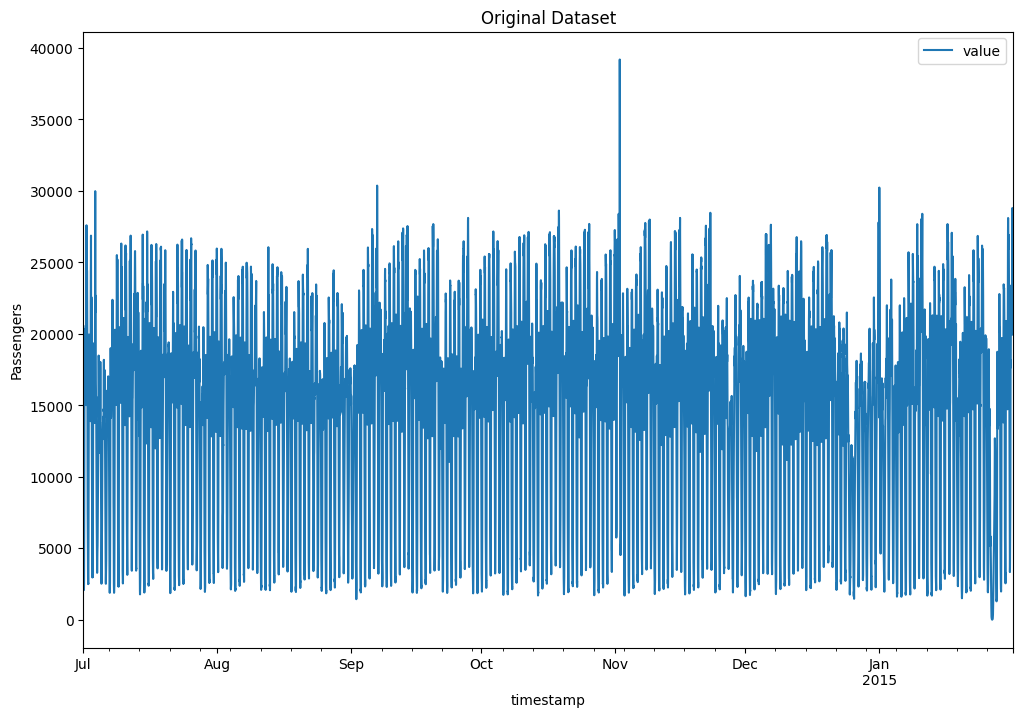

In [196]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("Passengers")
plt.title("Original Dataset")

In [197]:
data['label'] = 0
instances=  [
        [
            "2014-10-30 15:30:00.000000",
            "2014-11-03 22:30:00.000000"
        ],
        [
            "2014-11-25 12:00:00.000000",
            "2014-11-29 19:00:00.000000"
        ],
        [
            "2014-12-23 11:30:00.000000",
            "2014-12-27 18:30:00.000000"
        ],
        [
            "2014-12-29 21:30:00.000000",
            "2015-01-03 04:30:00.000000"
        ],
        [
            "2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"
        ]
    ]


In [198]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [199]:
data_w_ts=data.copy()
data_w_ts

,timestamp,value,label
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0
...,...,...,...
10315,2015-01-31 21:30:00,24670,0
10316,2015-01-31 22:00:00,25721,0
10317,2015-01-31 22:30:00,27309,0
10318,2015-01-31 23:00:00,26591,0


In [200]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week
0,2014-07-01 00:00:00,10844,0,1,7,0.0,1
1,2014-07-01 00:30:00,8127,0,1,7,0.5,1
2,2014-07-01 01:00:00,6210,0,1,7,1.0,1
3,2014-07-01 01:30:00,4656,0,1,7,1.5,1
4,2014-07-01 02:00:00,3820,0,1,7,2.0,1


In [201]:
cont_vars = ['value', 'hour_min']
cat_vars = ['day', 'month', 'day_of_week']
data.drop('timestamp', axis=1, inplace=True)

In [202]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,10844,0,0.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,8127,0,0.5,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,6210,0,1.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4656,0,1.5,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,3820,0,2.0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,24670,0,21.5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10316,25721,0,22.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10317,27309,0,22.5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10318,26591,0,23.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [203]:
print(data.keys())

Index(['value', 'label', 'hour_min', 'day_0', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'month_0',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')


In [204]:
# Splitting to train and test
test_ratio = 0.5
start = 0       # or int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [205]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [206]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [207]:
tr_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-0.639517,0,-1.692319,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,-1.042645,0,-1.620134,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,-1.327074,0,-1.547949,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,-1.557645,0,-1.475764,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,-1.681684,0,-1.403579,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.786045,0,-0.320804,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5156,0.671205,0,-0.248619,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5157,0.541082,0,-0.176434,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5158,0.306950,0,-0.104249,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [208]:
tst_data_scaled

,value,label,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
5160,0.376389,0,0.040121,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5161,0.281579,0,0.112306,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5162,0.241667,0,0.184492,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5163,0.480398,0,0.256677,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5164,0.510221,0,0.328862,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10315,1.411879,0,1.411637,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10316,1.567819,0,1.483822,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10317,1.803434,0,1.556007,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10318,1.696903,0,1.628192,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [209]:
train = tr_data_scaled[tr_data_scaled.label != 1]
train= train.drop(columns=['label'])
train

,value,hour_min,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,month_4,month_5,month_6,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,-0.639517,-1.692319,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,-1.042645,-1.620134,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,-1.327074,-1.547949,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,-1.557645,-1.475764,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,-1.681684,-1.403579,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.786045,-0.320804,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5156,0.671205,-0.248619,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5157,0.541082,-0.176434,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
5158,0.306950,-0.104249,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False


In [210]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [211]:
#Converting df to arrays
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [212]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [213]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [214]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [215]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [216]:
print(input_shape)

(47,)


In [217]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 15)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,824 (7.12 KB)

 Trainable params: 1,824 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 23)             │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 47)             │         1,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,496 (5.84 KB)

 Trainable params: 1,496 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

In [219]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [220]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=1000,
                        batch_size=128,
                        validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])


Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_4    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1727.0779 - val_loss: 1526.9120
Epoch 2/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1688.0492 - val_loss: 1489.0977
Epoch 3/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1644.2974 - val_loss: 1458.7040
Epoch 4/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1604.8215 - val_loss: 1417.6567
Epoch 5/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1564.0048 - val_loss: 1378.7704
Epoch 6/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1528.9375 - val_loss: 1348.5277
Epoch 7/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1486.5245 - val_loss: 1307.6847
Epoch 8/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1440.5148 - val_loss: 1271.7760
Epoch 9/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1411.1322 - val_loss: 1239.6093
Epoch 10/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1364.1656 - val_loss: 1195.4210
Epoch 11/1000
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1309.5389 - val_lo

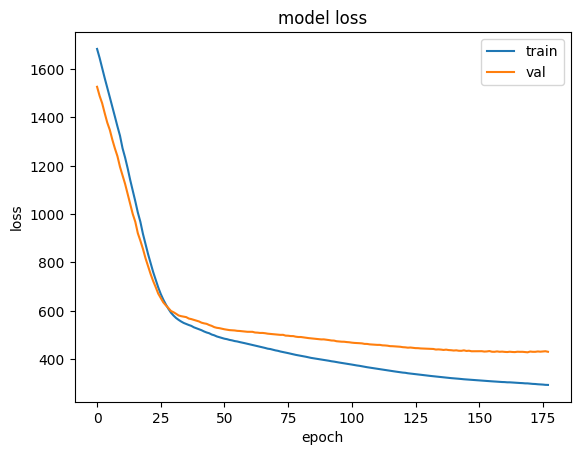

In [221]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [222]:
train_pred = vae_model.predict(train)[0]

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


In [223]:
mae_vector = get_error_term(train_pred, train, _rmse=True)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}')
error_thresh = np.max(mae_vector) -0.01
print(f'setting threshold on {error_thresh} ')

Avg error 0.21619807183742523
median error 0.1802087426185608
setting threshold on 0.43719010591506957 


(array([  6.,  13.,  19.,  24.,  58., 109., 152., 241., 364., 538., 444.,
        312., 245., 186., 114.,  83.,  81.,  47.,  46.,  52.,  79., 115.,
        147., 123., 105.,  99., 106.,  81.,  90.,  87.,  96., 103.,  86.,
         84.,  79., 100., 125.,  92.,  62.,  41.,  30.,  21.,  26.,  14.,
         12.,  10.,   8.,   3.,   1.,   1.]),
 array([0.08423182, 0.09149099, 0.09875015, 0.10600932, 0.11326849,
        0.12052765, 0.12778682, 0.13504599, 0.14230515, 0.14956431,
        0.15682349, 0.16408265, 0.17134181, 0.17860098, 0.18586014,
        0.1931193 , 0.20037848, 0.20763764, 0.2148968 , 0.22215597,
        0.22941513, 0.23667431, 0.24393347, 0.25119263, 0.25845179,
        0.26571095, 0.27297014, 0.2802293 , 0.28748846, 0.29474762,
        0.30200678, 0.30926597, 0.31652513, 0.32378429, 0.33104345,
        0.33830261, 0.34556177, 0.35282096, 0.36008012, 0.36733928,
        0.37459844, 0.3818576 , 0.38911679, 0.39637595, 0.40363511,
        0.41089427, 0.41815343, 0.4254126 , 0.

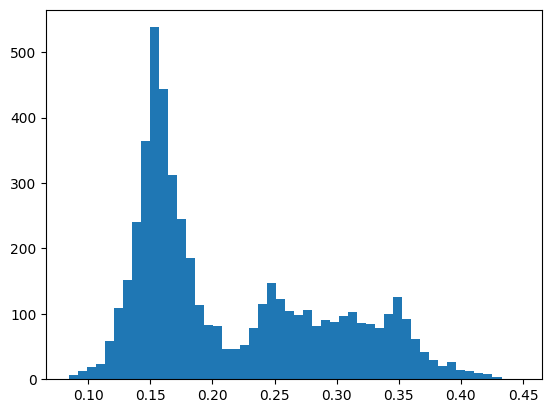

In [224]:
plt.hist(mae_vector, bins=50)

In [225]:
#Actual ratio of anomalies 
ratio=np.count_nonzero(labels_of_test) / len(labels_of_test)
print(ratio)

0.2005813953488372


In [226]:
pred = vae_model.predict(test)[0]
mae_vector_test = get_error_term(pred, test, _rmse=True)
print(f'Avg error {np.mean(mae_vector_test)}\nmedian error {np.median(mae_vector_test)}')
anomalies = (mae_vector_test > (error_thresh))

np.count_nonzero(anomalies) / len(anomalies)

  1/162 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
Avg error 0.28701648116111755
median error 0.26253682374954224


0.0034883720930232558

(array([  3.,   7.,  17.,  72., 196., 366., 520., 562., 587., 479., 323.,
        211., 127., 103.,  68.,  89.,  97.,  83., 103.,  95., 123., 124.,
        118., 122., 114., 149., 132.,  79.,  47.,  24.,   4.,   5.,   3.,
          4.,   2.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.18401273, 0.19232099, 0.20062923, 0.2089375 , 0.21724574,
        0.225554  , 0.23386225, 0.24217051, 0.25047877, 0.25878704,
        0.26709527, 0.27540353, 0.28371179, 0.29202005, 0.30032831,
        0.30863655, 0.31694481, 0.32525307, 0.33356133, 0.34186959,
        0.35017782, 0.35848609, 0.36679435, 0.37510261, 0.38341084,
        0.3917191 , 0.40002736, 0.40833563, 0.41664389, 0.42495212,
        0.43326038, 0.44156864, 0.4498769 , 0.45818517, 0.4664934 ,
        0.47480166, 0.48310992, 0.49141818, 0.49972644, 0.50803471,
        0.51634294, 0.52465117, 0.53295946, 0.54126769, 0.54957598,
        0.55788422, 0.56619245, 0.57450074, 0.

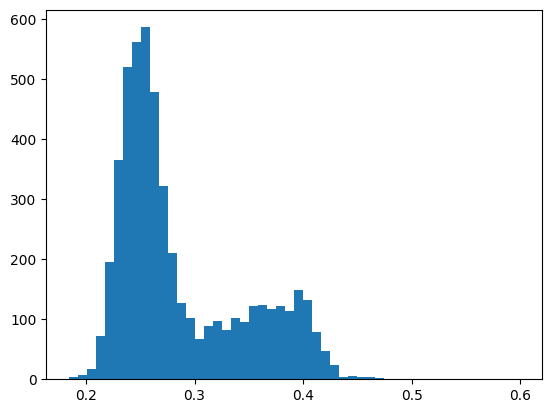

In [227]:
plt.hist(mae_vector_test, bins=50)

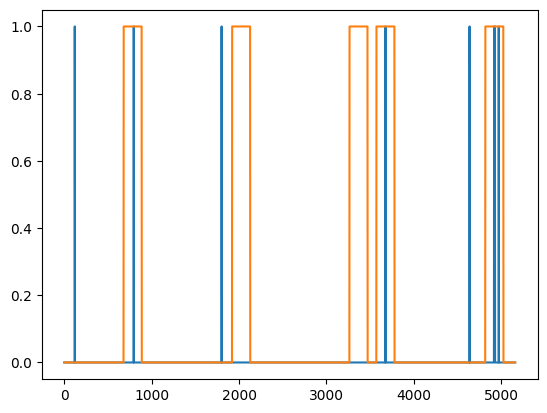

In [228]:
plt.plot(anomalies)
plt.plot(labels_of_test)

In [229]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(np.logical_not(labels_of_test), anomalies))

              precision    recall  f1-score   support

       False       0.20      0.99      0.33      1035
        True       0.17      0.00      0.00      4125

    accuracy                           0.20      5160
   macro avg       0.18      0.49      0.17      5160
weighted avg       0.17      0.20      0.07      5160



In [230]:
tst_data['anomaly']=anomalies
df = data_w_ts['timestamp']
ts = df.iloc[int(len(data_w_ts) * (1 - test_ratio)) :]
tst_data['timestamp']=ts
tst_data = tst_data[['timestamp','value', 'label','anomaly']]

C:\Users\99anj\AppData\Local\Temp\ipykernel_11364\3776165707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['anomaly']=anomalies
C:\Users\99anj\AppData\Local\Temp\ipykernel_11364\3776165707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_data['timestamp']=ts


Text(0.5, 1.0, 'Location of the Anomalies on the Time Series, Test Period')

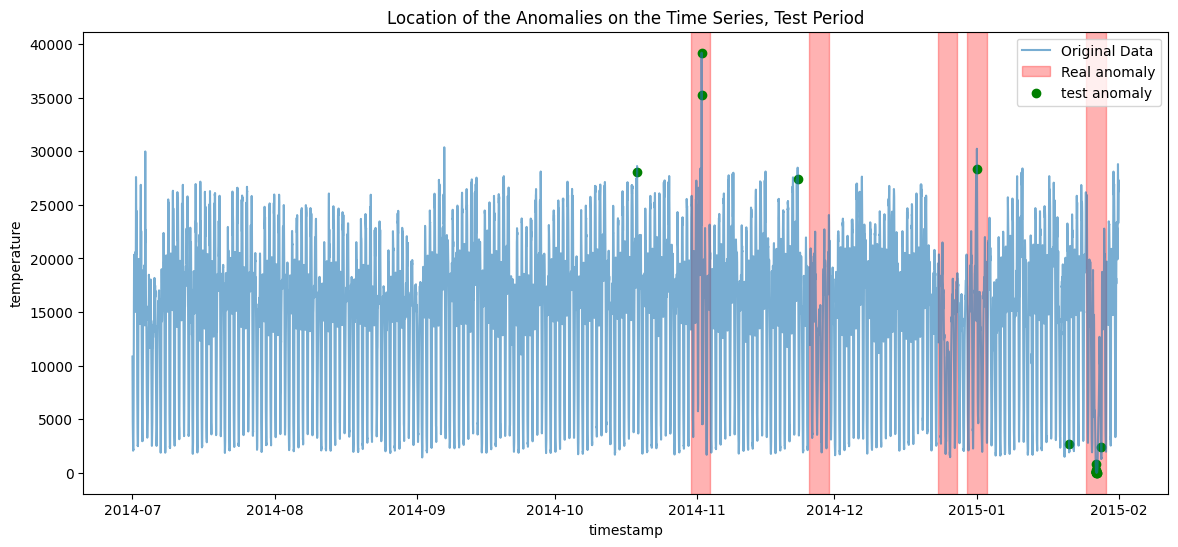

In [231]:
anomalies_ts = data_w_ts.loc[data_w_ts['label']==1, ('timestamp', 'value')]
testing = tst_data.loc[tst_data['anomaly']==True, ('timestamp', 'value')]
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_w_ts['timestamp'], data_w_ts['value'], label='Original Data', alpha=0.6)
ax.fill_between(data_w_ts['timestamp'], 0, 1, where=data_w_ts['label'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(),label='Real anomaly')
#ax.scatter(anomalies_ts['timestamp'], anomalies_ts['value'], color='red', label='Real anomaly')
ax.scatter(testing['timestamp'], testing['value'], color='green', label='test anomaly')
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("temperature")
plt.title("Location of the Anomalies on the Time Series, Test Period")